# 2018-06-08 - Comparaison modèle/humain
# Pour génerer les MC  : 2018-06-17 Notebook

# Le convo

In [2]:
import torch
import torchvision
from torchvision import transforms, datasets

data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

#train
train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=4, shuffle=True,
                                             num_workers=1, drop_last = True)

#test
test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=4,shuffle=True,
                                             num_workers=1, drop_last = True)

In [3]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 20)
        self.pool = nn.MaxPool2d(2,2)

        self.fc3 = nn.Linear(17496,1000)
        self.dropout = nn.Dropout(0.2)

        self.outlayer = nn.Linear(1000,16)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))

        x = x.view(x.size(0), -1) #reshape from conv to linear

        x = F.leaky_relu(self.fc3(x))
        x = self.dropout(x)

        x = self.outlayer(x)
        return x
        
model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(20, 20), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc3): Linear(in_features=17496, out_features=1000, bias=True)
  (dropout): Dropout(p=0.2)
  (outlayer): Linear(in_features=1000, out_features=16, bias=True)
)


In [4]:
#freeze layers after and including freezing_layer+1 (layers start at 0)
def freeze_layers(freezing_layer, nn_model = model) :
    for count,child in enumerate(model.children()) :
        if count < freezing_layer+1 : #to freeze at iteration 1
            print("Layer no. %s -- %s -- NOT FROZEN"% (count,child))
            for param in child.parameters():
                param.requires_grad = True
        else :
            print("Layer no. %s -- %s -- FROZEN"%(count, child))
            for param in child.parameters():
                param.requires_grad = False

#freeze all the layers except the unfrozen one
def freeze_all_layers(unfrozen_layer, nn_model = model) :
    for count,child in enumerate(model.children()) :
        if count == unfrozen_layer :
            print("Layer no. %s -- %s -- NOT FROZEN"% (count,child))
            for param in child.parameters():
                param.requires_grad = True
        else :
            print("Layer no. %s -- %s -- FROZEN"%(count, child))
            for param in child.parameters():
                param.requires_grad = False

#unfreeze every layers
def layers_microwave(nn_model = model) :
    for count,child in enumerate(model.children()) :
        for param in child.parameters():
            param.requires_grad = True

In [5]:
import torch.optim as optim
import time

#unfreeze before starting
layers_microwave(model)

criterion = nn.CrossEntropyLoss() #loss criterion
optimizer = optim.SGD(params = model.parameters(),lr=0.001, momentum=0.9)
epochs = 2 #nbr of epochs per layer
model_size = 4 #nbr of layers

print_interval = 50 #prints every p_i*4
tempo = []
acc = []

start_time = time.time()
print("Started training")

for epoch in range(epochs):  # nbr epochs
    for batch_idx, (data, target) in enumerate(train_loader): #nbr batch,in,out
        data, target = Variable(data), Variable(target)
        #On resize pour la sortie


        #init l'entrainement
        optimizer.zero_grad()
        net_out = model(data)

        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()

        #afficher la progression
        if batch_idx % print_interval == 0:
            #le print statement le plus illisible du monde
            print('Epoch: {} [{}/{} ({:.0f}%)]\t\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data[0]))
    tempo.append(epoch)
    acc.append(loss.data[0])


print("Finished training in  %.3f seconds " % (time.time() - start_time))

Started training


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1 [0/3840 (0%)]		Loss: 2.780261
Epoch: 1 [200/3840 (5%)]		Loss: 2.730807
Epoch: 1 [400/3840 (10%)]		Loss: 2.804087
Epoch: 1 [600/3840 (16%)]		Loss: 2.440760
Epoch: 1 [800/3840 (21%)]		Loss: 2.471992
Epoch: 1 [1000/3840 (26%)]		Loss: 2.250546
Epoch: 1 [1200/3840 (31%)]		Loss: 2.128938
Epoch: 1 [1400/3840 (36%)]		Loss: 2.084347
Epoch: 1 [1600/3840 (42%)]		Loss: 1.673000
Epoch: 1 [1800/3840 (47%)]		Loss: 1.167743
Epoch: 1 [2000/3840 (52%)]		Loss: 1.208961
Epoch: 1 [2200/3840 (57%)]		Loss: 0.485643
Epoch: 1 [2400/3840 (62%)]		Loss: 0.092124
Epoch: 1 [2600/3840 (68%)]		Loss: 0.139440
Epoch: 1 [2800/3840 (73%)]		Loss: 0.060365
Epoch: 1 [3000/3840 (78%)]		Loss: 0.060049
Epoch: 1 [3200/3840 (83%)]		Loss: 0.039726
Epoch: 1 [3400/3840 (89%)]		Loss: 0.169030
Epoch: 1 [3600/3840 (94%)]		Loss: 0.023138
Epoch: 1 [3800/3840 (99%)]		Loss: 0.004795


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 2 [0/3840 (0%)]		Loss: 0.003888
Epoch: 2 [200/3840 (5%)]		Loss: 0.103883
Epoch: 2 [400/3840 (10%)]		Loss: 0.028026
Epoch: 2 [600/3840 (16%)]		Loss: 0.435186
Epoch: 2 [800/3840 (21%)]		Loss: 0.006930
Epoch: 2 [1000/3840 (26%)]		Loss: 0.036822
Epoch: 2 [1200/3840 (31%)]		Loss: 0.035420
Epoch: 2 [1400/3840 (36%)]		Loss: 0.020118
Epoch: 2 [1600/3840 (42%)]		Loss: 0.081812
Epoch: 2 [1800/3840 (47%)]		Loss: 0.044806
Epoch: 2 [2000/3840 (52%)]		Loss: 0.058420
Epoch: 2 [2200/3840 (57%)]		Loss: 0.027945
Epoch: 2 [2400/3840 (62%)]		Loss: 0.045221
Epoch: 2 [2600/3840 (68%)]		Loss: 0.024116
Epoch: 2 [2800/3840 (73%)]		Loss: 0.185364
Epoch: 2 [3000/3840 (78%)]		Loss: 0.002476
Epoch: 2 [3200/3840 (83%)]		Loss: 0.015055
Epoch: 2 [3400/3840 (89%)]		Loss: 0.008820
Epoch: 2 [3600/3840 (94%)]		Loss: 0.003752
Epoch: 2 [3800/3840 (99%)]		Loss: 0.009988
Finished training in  1073.382 seconds 


In [6]:
# delete
test_loss = 0
correct = 0
model = model.eval()
for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)

    net_out = model(data)
    
    #somme des pertes du batch
    test_loss += criterion(net_out, target).data[0]
    pred = net_out.data.max(1)[1] #prediction
    correct += pred.eq(target.data).sum() #output du réseau

test_loss /= len(test_loader.dataset) #loss = loss/length set
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()



Test set: Average loss: 0.0289, Accuracy: 540/576 (93%)



## Convo - Psychophysique

In [7]:
#j'ai augmenté les B_theta et la longueur du test pour lisser les courbes
exp_info = 'convo_model_HIRES'
print (exp_info)

convo_model_HIRES


On défini la génération de MotionClouds :

In [37]:
import numpy as np
import MotionClouds as mc
import matplotlib.pyplot as plt
import os
import imageio
import random

downscale = 1
fig_width = 21
fx, fy, ft = mc.get_grids(mc.N_X/downscale, mc.N_Y/downscale, 1)

# generates a cloud of given theta and b_theta
def generate_random_cloud(theta, B_theta):
    mc_i = mc.envelope_gabor(fx, fy, ft, V_X=0., V_Y=0.,
                             B_V=0, theta=theta, B_theta=B_theta)
    im = mc.random_cloud(mc_i)
    im = (mc.rectif(im) * 255).astype('uint8')
    fname = './tmp/%s_%s.png' % (theta, B_theta)
    imageio.imwrite(fname, im[:, :, 0])
    return fname

On définit les paramètres et on teste :

In [38]:
from psychopy import visual, core, event
import MotionClouds as MC
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
from PIL import Image

test_length = 600
MC1 = generate_random_cloud(np.pi/2, B_theta=np.pi/2)
model = model.eval()


ans_list = []
N_B_thetas = 15
B_thetas = np.pi*np.logspace(-6, -1, N_B_thetas, base=2)
    
std_theta = np.pi/6

for trial in range(test_length):
    theta = np.clip(std_theta *  np.random.randn(), -np.pi/4, np.pi/4)

    # MC generation
    B_theta = B_thetas[random.randint(0, N_B_thetas-1)]

    MC1 = generate_random_cloud(np.pi/2, B_theta=B_theta)
    MC2 = generate_random_cloud(np.pi/2 - theta, B_theta=B_theta)  # if shift = 2

    varimgmc2 = data_transform(Image.open(MC2))
    #varimgmc2 = data_transform(Image.open('16_clouds_easy/0.0/B0 1.40625.png'))
    varimgmc2 = Variable(varimgmc2)
    varimgmc2 = varimgmc2.unsqueeze(0)
    
    net_ans = model(varimgmc2)
    pred = net_ans.data.max(1)[1] #prediction
    #print(pred)
    #correct = (np.sign(theta) > 0) and (pred[0]>8)
    if np.sign(theta) > 0 and pred[0] > 8 :
        correct = True
    if np.sign(theta) < 0 and pred[0] <= 8:
        correct = True
    else :
        correct = False
    print('At trial ', trial, 'Angle=', '%3.3f' % (theta*180/np.pi), 'answer is ', pred[0], '(correct=', correct, '); bandwidth=', '%.3f' % (B_theta*180/np.pi))

    # Output shape per trial is : trial number, shift direction, answered shift and b_theta
    if pred[0] >8 :
        ans_list.append([trial, theta, 'left', B_theta])
    if pred[0] <= 8 :
        ans_list.append([trial, theta, 'right', B_theta])


ValueError: Could not find a format to write the specified file in mode 'i'

In [12]:
import pickle
pickle.dump(ans_list, open('./psychophysics_data/Psy_discrim_final_%s.p' % exp_info, 'wb'))

# Le Ring

BiRNN(
  (rnn): LSTM(49, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (conv1): Conv2d(1, 8, kernel_size=(30, 30), stride=(1, 1))
  (conv2): Conv2d(1, 8, kernel_size=(30, 30), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=113, out_features=16, bias=True)
)
Start training


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:132: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:133: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/60], Step [100/480], Loss: 2.1057
Epoch [1/60], Step [200/480], Loss: 2.5178
Epoch [1/60], Step [300/480], Loss: 1.8250
Epoch [1/60], Step [400/480], Loss: 2.0128
Epoch [2/60], Step [100/480], Loss: 1.5833
Epoch [2/60], Step [200/480], Loss: 1.2951
Epoch [2/60], Step [300/480], Loss: 1.9595
Epoch [2/60], Step [400/480], Loss: 1.3452
Epoch [3/60], Step [100/480], Loss: 1.1535
Epoch [3/60], Step [200/480], Loss: 1.3358
Epoch [3/60], Step [300/480], Loss: 1.4645
Epoch [3/60], Step [400/480], Loss: 1.7438
Epoch [4/60], Step [100/480], Loss: 1.9155
Epoch [4/60], Step [200/480], Loss: 1.5136
Epoch [4/60], Step [300/480], Loss: 1.3291
Epoch [4/60], Step [400/480], Loss: 0.8548
Epoch [5/60], Step [100/480], Loss: 1.1973
Epoch [5/60], Step [200/480], Loss: 0.5839
Epoch [5/60], Step [300/480], Loss: 0.5419
Epoch [5/60], Step [400/480], Loss: 0.9108
Epoch [6/60], Step [100/480], Loss: 0.4196
Epoch [6/60], Step [200/480], Loss: 0.3486
Epoch [6/60], Step [300/480], Loss: 0.4050
Epoch [6/60

Epoch [48/60], Step [100/480], Loss: 0.0542
Epoch [48/60], Step [200/480], Loss: 0.0034
Epoch [48/60], Step [300/480], Loss: 0.0953
Epoch [48/60], Step [400/480], Loss: 0.2237
Epoch [49/60], Step [100/480], Loss: 0.0002
Epoch [49/60], Step [200/480], Loss: 0.1292
Epoch [49/60], Step [300/480], Loss: 0.1063
Epoch [49/60], Step [400/480], Loss: 0.2350
Epoch [50/60], Step [100/480], Loss: 0.1534
Epoch [50/60], Step [200/480], Loss: 0.2230
Epoch [50/60], Step [300/480], Loss: 0.0887
Epoch [50/60], Step [400/480], Loss: 0.1095
Epoch [51/60], Step [100/480], Loss: 0.0603
Epoch [51/60], Step [200/480], Loss: 0.0012
Epoch [51/60], Step [300/480], Loss: 0.0008
Epoch [51/60], Step [400/480], Loss: 0.0071
Epoch [52/60], Step [100/480], Loss: 0.0604
Epoch [52/60], Step [200/480], Loss: 0.1083
Epoch [52/60], Step [300/480], Loss: 0.2643
Epoch [52/60], Step [400/480], Loss: 0.0002
Epoch [53/60], Step [100/480], Loss: 0.0010
Epoch [53/60], Step [200/480], Loss: 0.0617
Epoch [53/60], Step [300/480], L

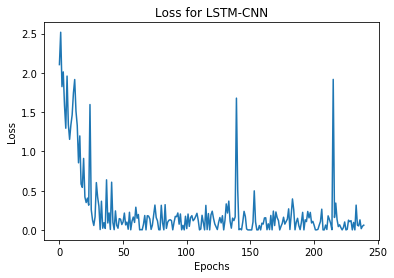

In [2]:
"""
Created on Tue May 15 11:25:41 2018

@author: hugo
"""
from torch.autograd import Variable
import torch 
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F

#Transform
data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((128,128)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

#Train
train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=8, shuffle=True,
                                             num_workers=1)

#Test
test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=8,shuffle=False,
                                             num_workers=1)

###################################################################################

# Hyper-parameters
sequence_length = 49
input_size = 49
hidden_size = 128
num_layers = 2
num_classes = 16
batch_size = 8
num_epochs = 60
learning_rate = 0.003

###################################################################################

class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout = 0.3)
        self.conv1 = nn.Conv2d(1,8,30)
        self.conv2 = nn.Conv2d(1,8,30)
        self.pool1 = nn.MaxPool2d(2,2)
        self.pool2 = nn.MaxPool2d(2,2)
        #self.drop = nn.Dropout(0.2)

        self.fc = nn.Linear(113 , 16)  # 2 for bidirection
    
    def forward(self, x):
        #print('Input %s' % str(x.size()))

        out = self.pool1(F.relu(self.conv1(x)))
        #print('Convoluted %s' % str(x.size()))

        # Init
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)
        h0 = Variable(h0).cuda()
        c0 = Variable(c0).cuda()
        
        out = out[:,-1,:,:]
        #print('Resized for RNN %s' % str(x.size()))
        
        # LSTM forward
        out, _ = self.rnn(out, (h0,c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        #print('After RNN %s' % str(out.size()))
        
        out = out.unsqueeze(1)
        #print(out.size())
        out = self.pool2(F.relu(self.conv2(out)))
        #print(out.size())
        out = out[:,-1,:,:]
        #Dropout
        #out = self.drop(out)
        #print(out.size())
        
        out = out[:,-1,:]
        # LSTM output
        out = self.fc(out)
        #print('Reshaped for output %s \n'%  str(out.size()))

        return out

model = BiRNN(input_size, hidden_size, num_layers, num_classes).cuda()
print(model)

###################################################################################

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

###################################################################################

#plotting list
loss_list = []
time_list = []
t = 0

print("Start training")
# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.data[0]))
            loss_list.append(loss.data[0])
            time_list.append(t)
            t+=1

correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images).cuda()
    labels = Variable(labels).cuda()

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += predicted.eq(labels.data).sum()

print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(np.asarray(time_list)[::4], loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for LSTM-CNN')
plt.show()
            

In [131]:
#NOW FOR THE PSYCHOPHYSICS
import numpy as np
import MotionClouds as mc
import matplotlib.pyplot as plt
import os
import imageio
import random

exp_info = 'model_ring_HIRES'
print (exp_info)

downscale = 1
fig_width = 21
fx, fy, ft = mc.get_grids(mc.N_X/downscale, mc.N_Y/downscale, 1)

# generates a cloud of given theta and b_theta
def generate_random_cloud(theta, B_theta):
    mc_i = mc.envelope_gabor(fx, fy, ft, V_X=0., V_Y=0.,
                             B_V=0, theta=theta, B_theta=B_theta)
    
    im = mc.random_cloud(mc_i)
    im = (mc.rectif(im) * 255).astype('uint8')
    fname = './tmp/%s_%s.bmp' % (theta, B_theta)
    imageio.imwrite(uri = fname,im = im[:, :, 0], format = 'bmp')
    return fname

model_ring_HIRES


In [132]:
from psychopy import visual, core, event
import MotionClouds as MC
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob

files = glob.glob('./tmp/*')
if not os.path.exists('./tmp'): #si le folder n'existe pas on le crée
        os.makedirs('./tmp')
        
        
test_length = 600
MC1 = generate_random_cloud(np.pi/2, B_theta=np.pi/2)
model = model.eval()

ans_list = []
N_B_thetas = 15
B_thetas = np.pi*np.logspace(-6, -1, N_B_thetas, base=2)
    
std_theta = np.pi/6

for trial in range(test_length):
    theta = np.clip(std_theta *  np.random.randn(), -np.pi/4, np.pi/4)

    # MC generation
    B_theta = B_thetas[random.randint(0, N_B_thetas-1)]

    MC1 = generate_random_cloud(np.pi/2, B_theta=B_theta)
    MC2 = generate_random_cloud(np.pi/2 - theta, B_theta=B_theta)  # if shift = 2

    varimgmc2 = data_transform(Image.open(MC2))
    #varimgmc2 = data_transform(Image.open('16_clouds_easy/0.0/B0 1.40625.png'))
    varimgmc2 = Variable(varimgmc2).cuda()
    varimgmc2 = varimgmc2.unsqueeze(0)
    
    net_ans = model(varimgmc2)
    pred = net_ans.data.max(1)[1] #prediction
    #print(pred)
    #correct = (np.sign(theta) > 0) and (pred[0]>8)
    if np.sign(theta) > 0 and pred[0] > 8 :
        correct = True
    if np.sign(theta) < 0 and pred[0] <= 8:
        correct = True
    else :
        correct = False
    print('At trial ', trial, 'Angle=', '%3.3f' % (theta*180/np.pi), 'answer is ', pred[0], '(correct=', correct, '); bandwidth=', '%.3f' % (B_theta*180/np.pi))

    # Output shape per trial is : trial number, shift direction, answered shift and b_theta
    if pred[0] >8 :
        ans_list.append([trial, theta, 'left', B_theta])
    if pred[0] <= 8 :
        ans_list.append([trial, theta, 'right', B_theta])

#cleanup temp
for f in files:
    os.remove(f)


At trial  0 Angle= -7.129 answer is  tensor(8, device='cuda:0') (correct= True ); bandwidth= 4.614
At trial  1 Angle= 1.881 answer is  tensor(6, device='cuda:0') (correct= False ); bandwidth= 42.826
At trial  2 Angle= 16.309 answer is  tensor(7, device='cuda:0') (correct= False ); bandwidth= 33.435
At trial  3 Angle= -39.144 answer is  tensor(11, device='cuda:0') (correct= False ); bandwidth= 9.697
At trial  4 Angle= 14.201 answer is  tensor(6, device='cuda:0') (correct= False ); bandwidth= 3.602
At trial  5 Angle= 26.721 answer is  tensor(5, device='cuda:0') (correct= False ); bandwidth= 15.910
At trial  6 Angle= -8.056 answer is  tensor(8, device='cuda:0') (correct= True ); bandwidth= 7.571
At trial  7 Angle= -3.123 answer is  tensor(4, device='cuda:0') (correct= True ); bandwidth= 70.264
At trial  8 Angle= 23.580 answer is  tensor(5, device='cuda:0') (correct= False ); bandwidth= 15.910
At trial  9 Angle= 24.329 answer is  tensor(6, device='cuda:0') (correct= False ); bandwidth= 42.

At trial  85 Angle= 12.014 answer is  tensor(9, device='cuda:0') (correct= False ); bandwidth= 42.826
At trial  86 Angle= -34.748 answer is  tensor(10, device='cuda:0') (correct= False ); bandwidth= 15.910
At trial  87 Angle= 3.943 answer is  tensor(8, device='cuda:0') (correct= False ); bandwidth= 9.697
At trial  88 Angle= 28.336 answer is  tensor(12, device='cuda:0') (correct= False ); bandwidth= 70.264
At trial  89 Angle= -24.639 answer is  tensor(10, device='cuda:0') (correct= False ); bandwidth= 12.421
At trial  90 Angle= 14.104 answer is  tensor(6, device='cuda:0') (correct= False ); bandwidth= 42.826
At trial  91 Angle= 21.686 answer is  tensor(6, device='cuda:0') (correct= False ); bandwidth= 2.812
At trial  92 Angle= 15.788 answer is  tensor(7, device='cuda:0') (correct= False ); bandwidth= 33.435
At trial  93 Angle= -35.365 answer is  tensor(10, device='cuda:0') (correct= False ); bandwidth= 20.379
At trial  94 Angle= -29.266 answer is  tensor(10, device='cuda:0') (correct= F

At trial  165 Angle= -45.000 answer is  tensor(11, device='cuda:0') (correct= False ); bandwidth= 4.614
At trial  166 Angle= 5.063 answer is  tensor(7, device='cuda:0') (correct= False ); bandwidth= 42.826
At trial  167 Angle= 30.003 answer is  tensor(5, device='cuda:0') (correct= False ); bandwidth= 3.602
At trial  168 Angle= 7.274 answer is  tensor(7, device='cuda:0') (correct= False ); bandwidth= 4.614
At trial  169 Angle= 19.315 answer is  tensor(6, device='cuda:0') (correct= False ); bandwidth= 20.379
At trial  170 Angle= -10.442 answer is  tensor(9, device='cuda:0') (correct= False ); bandwidth= 54.856
At trial  171 Angle= -7.186 answer is  tensor(8, device='cuda:0') (correct= True ); bandwidth= 4.614
At trial  172 Angle= -24.595 answer is  tensor(9, device='cuda:0') (correct= False ); bandwidth= 3.602
At trial  173 Angle= -6.777 answer is  tensor(7, device='cuda:0') (correct= True ); bandwidth= 12.421
At trial  174 Angle= 6.353 answer is  tensor(6, device='cuda:0') (correct= Fal

At trial  245 Angle= -45.000 answer is  tensor(11, device='cuda:0') (correct= False ); bandwidth= 3.602
At trial  246 Angle= 45.000 answer is  tensor(6, device='cuda:0') (correct= False ); bandwidth= 54.856
At trial  247 Angle= 2.369 answer is  tensor(7, device='cuda:0') (correct= False ); bandwidth= 5.911
At trial  248 Angle= -19.141 answer is  tensor(9, device='cuda:0') (correct= False ); bandwidth= 33.435
At trial  249 Angle= 45.000 answer is  tensor(11, device='cuda:0') (correct= False ); bandwidth= 26.103
At trial  250 Angle= 6.457 answer is  tensor(7, device='cuda:0') (correct= False ); bandwidth= 2.812
At trial  251 Angle= -45.000 answer is  tensor(6, device='cuda:0') (correct= True ); bandwidth= 90.000
At trial  252 Angle= -39.971 answer is  tensor(11, device='cuda:0') (correct= False ); bandwidth= 7.571
At trial  253 Angle= 8.754 answer is  tensor(6, device='cuda:0') (correct= False ); bandwidth= 42.826
At trial  254 Angle= -5.899 answer is  tensor(8, device='cuda:0') (correct

At trial  328 Angle= -8.853 answer is  tensor(9, device='cuda:0') (correct= False ); bandwidth= 33.435
At trial  329 Angle= -32.302 answer is  tensor(9, device='cuda:0') (correct= False ); bandwidth= 42.826
At trial  330 Angle= 12.460 answer is  tensor(6, device='cuda:0') (correct= False ); bandwidth= 5.911
At trial  331 Angle= -43.949 answer is  tensor(11, device='cuda:0') (correct= False ); bandwidth= 4.614
At trial  332 Angle= -28.432 answer is  tensor(10, device='cuda:0') (correct= False ); bandwidth= 4.614
At trial  333 Angle= 8.815 answer is  tensor(7, device='cuda:0') (correct= False ); bandwidth= 7.571
At trial  334 Angle= -36.148 answer is  tensor(10, device='cuda:0') (correct= False ); bandwidth= 42.826
At trial  335 Angle= -7.587 answer is  tensor(8, device='cuda:0') (correct= True ); bandwidth= 20.379
At trial  336 Angle= 31.157 answer is  tensor(5, device='cuda:0') (correct= False ); bandwidth= 3.602
At trial  337 Angle= -31.998 answer is  tensor(10, device='cuda:0') (corr

At trial  411 Angle= 38.025 answer is  tensor(4, device='cuda:0') (correct= False ); bandwidth= 15.910
At trial  412 Angle= -12.482 answer is  tensor(8, device='cuda:0') (correct= True ); bandwidth= 9.697
At trial  413 Angle= -45.000 answer is  tensor(11, device='cuda:0') (correct= False ); bandwidth= 2.812
At trial  414 Angle= 9.910 answer is  tensor(7, device='cuda:0') (correct= False ); bandwidth= 42.826
At trial  415 Angle= 35.787 answer is  tensor(6, device='cuda:0') (correct= False ); bandwidth= 70.264
At trial  416 Angle= 35.835 answer is  tensor(6, device='cuda:0') (correct= False ); bandwidth= 33.435
At trial  417 Angle= 34.603 answer is  tensor(7, device='cuda:0') (correct= False ); bandwidth= 90.000
At trial  418 Angle= 11.474 answer is  tensor(7, device='cuda:0') (correct= False ); bandwidth= 5.911
At trial  419 Angle= -7.876 answer is  tensor(8, device='cuda:0') (correct= True ); bandwidth= 9.697
At trial  420 Angle= 15.708 answer is  tensor(6, device='cuda:0') (correct= F

At trial  495 Angle= -28.810 answer is  tensor(10, device='cuda:0') (correct= False ); bandwidth= 33.435
At trial  496 Angle= 17.992 answer is  tensor(6, device='cuda:0') (correct= False ); bandwidth= 26.103
At trial  497 Angle= 5.983 answer is  tensor(7, device='cuda:0') (correct= False ); bandwidth= 3.602
At trial  498 Angle= -9.784 answer is  tensor(11, device='cuda:0') (correct= False ); bandwidth= 90.000
At trial  499 Angle= 45.000 answer is  tensor(4, device='cuda:0') (correct= False ); bandwidth= 3.602
At trial  500 Angle= -45.000 answer is  tensor(11, device='cuda:0') (correct= False ); bandwidth= 12.421
At trial  501 Angle= -10.419 answer is  tensor(7, device='cuda:0') (correct= True ); bandwidth= 4.614
At trial  502 Angle= 8.473 answer is  tensor(6, device='cuda:0') (correct= False ); bandwidth= 54.856
At trial  503 Angle= -9.041 answer is  tensor(4, device='cuda:0') (correct= True ); bandwidth= 90.000
At trial  504 Angle= -17.862 answer is  tensor(9, device='cuda:0') (correc

At trial  579 Angle= -42.301 answer is  tensor(11, device='cuda:0') (correct= False ); bandwidth= 20.379
At trial  580 Angle= 42.754 answer is  tensor(4, device='cuda:0') (correct= False ); bandwidth= 54.856
At trial  581 Angle= -27.044 answer is  tensor(10, device='cuda:0') (correct= False ); bandwidth= 12.421
At trial  582 Angle= 3.336 answer is  tensor(11, device='cuda:0') (correct= False ); bandwidth= 54.856
At trial  583 Angle= 8.297 answer is  tensor(7, device='cuda:0') (correct= False ); bandwidth= 26.103
At trial  584 Angle= 13.288 answer is  tensor(7, device='cuda:0') (correct= False ); bandwidth= 7.571
At trial  585 Angle= -9.588 answer is  tensor(8, device='cuda:0') (correct= True ); bandwidth= 15.910
At trial  586 Angle= 42.500 answer is  tensor(4, device='cuda:0') (correct= False ); bandwidth= 4.614
At trial  587 Angle= 33.035 answer is  tensor(5, device='cuda:0') (correct= False ); bandwidth= 4.614
At trial  588 Angle= -24.424 answer is  tensor(9, device='cuda:0') (correc

In [146]:
import pickle
pickle.dump(ans_list, open('./psychophysics_data/Psy_discrim_final_%s.p' % exp_info, 'wb'))

# Trash

In [52]:
varimgmc2 = data_transform(Image.open('16_clouds_easy/2.722713633111154/B0 10.928413651643268.png'))
varimgmc2 = Variable(varimgmc2)
varimgmc2 = varimgmc2.unsqueeze(0)

net_ans = model(varimgmc2)
print(net_ans.data.max(1)[1])


 13
[torch.LongTensor of size 1]

